In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt


In [7]:
sim_1: SimulationStudy = SimulationStudy(p=50, mean_correlation=0.3, n=5000, degree=3)
sim_2: SimulationStudy = SimulationStudy(p=100,mean_correlation=0.3,n=5000, degree=2)
simulation_1 = sim_1.create_dataset()
simulation_2 = sim_2.create_dataset()



In [ ]:
treated = simulation_1[simulation_1["T"] == 1]
x_var_treat = treated["X6"]
plt.plot(x_var_treat, treated["y"], 'o')

#untreated = simulation_1[simulation_1["T"] == 0]
#x_var_untreat = untreated["X1"]
#plt.plot(x_var_untreat, untreated["y"], 'o')

#fit polynomial regression
poly_fit = np.polyfit(x_var_treat, treated["CATE"], 2)
poly_fit_fn = np.poly1d(poly_fit)
plt.plot(treated["X6"], poly_fit_fn(treated["X6"]))


In [ ]:
#df_nontreat = simulation_1[simulation_1["T"] == 0]
#plt.plot(df_nontreat["y"], df_nontreat["mu_x"], 'o')

plt.plot(treated["mu_x"], treated["CATE"], 'o')

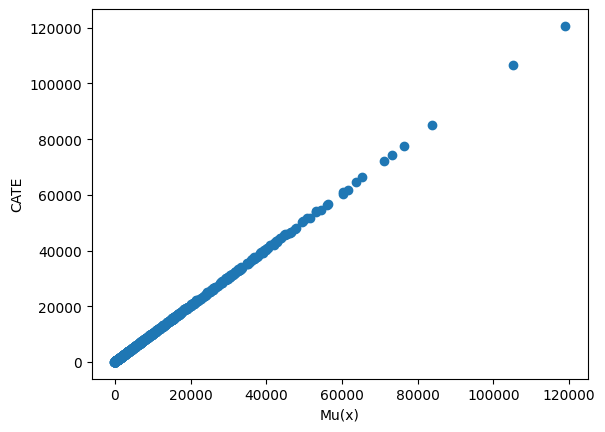

In [8]:
sim_test: SimulationStudy = SimulationStudy(p=500, mean_correlation=0.3, n=2000, degree=2)
sim_test = sim_test.create_dataset()
treated = sim_test[sim_test["T"] == 1]
plt.plot(treated["mu_x"], treated["CATE"], 'o')
plt.xlabel("Mu(x)")
plt.ylabel("CATE")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

x=treated[["mu_x"]]
y=treated[["CATE"]]


reg = LinearRegression().fit(x, y)
reg.score(x, y)

0.9998931515491757

In [ ]:
plt.plot(simulation_1["CATE"], simulation_2["CATE"], 'o')